# Batch Lamda1050 jump correction script and smoothing

### Author: Vinicio Soto, CICIMA
### This script works with raw Lambdas1050's ASC files in batch. It corrects Lambdas1050's detector jump between 857 nm and 858 nm and performs a Savitzky-Golay filtering on the corrected data

#### exclusion_list.txt: You can add a file with this name to the folder with the data to exclude any file with that name

This script reads every l1050 file in folder and its subfolders and create a unique average, jump_corrected_files, report and std_dev folders
It creates sections for each folder with its information


### Dependencies

In [1]:
import pandas as pd #Data analysis
import numpy as np  #Array and numeric methods
from matplotlib.backends.backend_pdf import PdfPages #Print PDFS
import matplotlib #Print graphs
import matplotlib.pyplot as plt #Print graphs
import os #operating system
import re #regular expression manipulation
from datetime import datetime #date and time methods

#import spectraltools
#This script requires the file spectraltools.py to work
import sys
# Add the external folder to the system path
current_dir = os.getcwd()
external_folder_path = os.path.abspath(os.path.join(current_dir, '../libraries'))
sys.path.append(external_folder_path)


#This line of code allow us to access data in colab
#functionality to reload modules

import importlib
import spectraltools
import metrics
import datapath_selector

# clear the import cache
importlib.reload(metrics)
importlib.reload(spectraltools)
importlib.reload(datapath_selector)
# now you can import my_class and it'll be updated
from metrics import *
from spectraltools import *
from datapath_selector import get_paths
from pathlib import Path




### Instructions:

Write your archive folders' path in file_folder_data_path list

In [2]:
#parent folder path

#file_folder_data_path =[ #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\CICIMA-2024-05-REFLECTANCE\DORSAL",
                         #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\CICIMA-2024-05-REFLECTANCE\VENTRAL",
                         #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\CICIMA-2024-03-REFLECTANCE\without iris nor lens",
                         #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\2024-04-INBUCR-REFLECTANCE",
                         #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\2023-03-CICIMAUCR-2-REFLECTANCE",
                         #r"C:\Users\esteb\cicima\escarabajos\L1050_data\CICIMA-2024-05-REFLECTANCE\DORSAL"
                       #]
parent_folder_data_path = Path(r"../test/data/test_step_jump_correction/files") 
report_path = (parent_folder_data_path.parent / "reports" ) / parent_folder_data_path.name
print(report_path)

..\test\data\test_step_jump_correction\reports\files


#### Collections

In [3]:
"""OPTIONS: cicima_laptop, colaboratory, wfh, cicima_desktop
    """
collection_paths = get_paths()
print(collection_paths)

inbio_2018_2019_collection = Specimen_Collection("INBIO", collection_paths["2018_2019_inbio_collection_path"] , collection_paths["2018_2019_inbio_collection_metadata"] , "HIGH")
angsol_collection = Specimen_Collection("ANGSOL", collection_paths["angsol_collection_path"] , collection_paths["angsol_collection_metadata"] , "HIGH")
angsol_collection.set_description("ANGSOL collection has specimens that belong to Angel Solís. The confidence that we have about specimen identification is high.")

cicimaucr_collection = Specimen_Collection("CICIMAUCR1", collection_paths["cicimaucr_collection_path"] , collection_paths["cicima_ucr_metadata"] , "HIGH")
cicimaucr_collection_2 = Specimen_Collection("CICIMAUCR2", collection_paths["cicimaucr_collection_2_path"] , collection_paths["cicima_ucr_metadata"] , "HIGH")
cicimaucr_collection_3 = Specimen_Collection("CICIMAUCR3", collection_paths["cicimaucr_collection_3_path"] , collection_paths["cicima_ucr_metadata"] , "HIGH")
inbucr_collection = Specimen_Collection("INBUCR", collection_paths["inbucr_collection_path"] , collection_paths["inbucr_metadata"] , "HIGH")
bioucr_collection = Specimen_Collection("BIOUCR", collection_paths["bioucr_collection_path"] , collection_paths["bioucr_metadata"] , "LOW")

collection_list = [
                    inbio_2018_2019_collection,
                    angsol_collection,
                    cicimaucr_collection,
                    cicimaucr_collection_2,
                    cicimaucr_collection_3,
                    inbucr_collection,
                    bioucr_collection,
                    ]
print(collection_list)

{'2018_2019_inbio_collection_path': WindowsPath('C:/Users/EstebanSoto/Jupyter/escarabajos/CRAIC_data/Mediciones Chrysina'), '2018_2019_inbio_collection_metadata': WindowsPath('C:/Users/EstebanSoto/Jupyter/escarabajos/collections/datos_especimenes_chrysina.txt'), 'angsol_collection_path': WindowsPath('C:/Users/EstebanSoto/Jupyter/escarabajos/L1050_data/ANGSOL/average'), 'angsol_collection_metadata': WindowsPath('C:/Users/EstebanSoto/Jupyter/escarabajos/collections/CICIMA-beetles-general-inventory - ANGSOL.txt'), 'cicimaucr_collection_path': WindowsPath('C:/Users/EstebanSoto/Jupyter/escarabajos/L1050_data/TRA_data_CICIMA_INBUCR/CICIMAUCR/reflectance'), 'cicimaucr_collection_2_path': WindowsPath('C:/Users/EstebanSoto/Jupyter/escarabajos/L1050_data/CICIMA-2024-01-REFLECTANCE/average'), 'cicimaucr_collection_3_path': WindowsPath('C:/Users/EstebanSoto/Jupyter/escarabajos/L1050_data/CICIMA-2024-03-REFLECTANCE/without iris nor lens/average'), 'cicimaucr_collection_4_path': WindowsPath('C:/User

### Constants
Define your constants

In [4]:
#determine 
markersize = 1
#date
date = str(datetime.today().date())

### Functions

#### Check if it is a L1050 file or a CRAIC file

#### Get genera and species function

### Correction process function

In [5]:
def jump_correction(Spectrum):
    """Receives a l1050 spectrum and corrects its detector jump"""
    metadata = Spectrum.get_metadata()
    df = Spectrum.get_dataframe()
    
    #measuring_mode
    measuring_mode = metadata["measuring_mode"]
    
    #convert columns to float
    df['wavelength'] = df['wavelength'].astype(float)
    df[measuring_mode] = df[measuring_mode].astype(float)
    

    #This code finds the rows before and after the detector change
    #freq1 is the frequency before the change and freq2 is the frequency after the change
    wavelenght1 = 857.000000 #857
    wavelenght2 = 858.000000 #858
    
    #print("Loc")
    row1 = df.loc[ df['wavelength'] == wavelenght1]
    row2 = df.loc[ df['wavelength'] == wavelenght2]
    row12 = df.loc[ df['wavelength'] == wavelenght1-1]
    row13 = df.loc[ df['wavelength'] == wavelenght1-2]
    row14 = df.loc[ df['wavelength'] == wavelenght1-3]
    row15 = df.loc[ df['wavelength'] == wavelenght1-4]
    
    #This code finds the values corresponding to those frequencies and creates a correction factor
    
    try:
        data1 = row1.iat[0,1]
        data2 = row2.iat[0,1]
        data22 = row12.iat[0,1]
        data23 = row13.iat[0,1]
        data24 = row14.iat[0,1]
        data25 = row15.iat[0,1]
    
        data1_avg = (data1 + data22+data23)/3 #+data24+data25)/5
        data2_avg = (data2)
        correction_factor= data1_avg/data2_avg  
    
        #Multiply all frequencies equal or greater than freq2 by correction_factor
        df2 = df
        df2.loc[df2["wavelength"] >= wavelenght2 , [measuring_mode]] *= correction_factor
        
        
        return df
    except Exception as e:
        
        print(e)
        return pd.DataFrame([])
    
    

### Define Savitzky-Golay Filter

In [6]:
from scipy.signal import savgol_filter

def savitzky_golay_filter(metadata, df) -> pd.DataFrame:
    """Defines a Savitzky Golay Filter: Basically, smooths out the function. https://es.wikipedia.org/wiki/Filtro_de_Savitzky%E2%80%93Golay"""
    measuring_mode = metadata["measuring_mode"]
    y = df[measuring_mode] = df[measuring_mode].astype(float)
    
    # Apply Savitzky-Golay filter
    window_length = 21  # Window length (odd number)
    polyorder = 2  # Polynomial order
    y_smooth = savgol_filter(y, window_length, polyorder)
    
    #create new dataframe
    df_smooth = pd.DataFrame([])
    df_smooth["wavelength"] =df["wavelength"]
    df_smooth[measuring_mode] = y_smooth
    
    return df_smooth
    

### Define function that filters selected extensions

In [7]:
def list_all_filepaths(parent_folder):
    filepaths = []
    
    # Walk through the directory
    for root, dirs, files in os.walk(parent_folder):
        for file in files:
            # Combine the root directory with the file name to get the full path
            filepath = os.path.join(root, file)
            filepaths.append(filepath)
    
    return filepaths
file_list = list_all_filepaths(parent_folder_data_path)
print(f"{file_list=}")

file_list=['..\\test\\data\\test_step_jump_correction\\files\\1037298L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298L2.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298L3.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298R1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298R2.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298R3.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299L2.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299L3.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299R1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299R2.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299R3.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037308L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037308L2.csv', '..\\test\\data\\test_step_jump_correction\\files\\

In [8]:
def get_exclusion_list(file_list):
        """Only files whose name is in the exclusion list"""
        #file extension
        file_extension = "exclusion_list"
    
        # filters a list of strings to create a new list containing only the elements that have exclusion_list"
    
        def filter_substring_elements(path_strings, substring):
            filtered_paths = [path for path in path_strings if substring in path]
            return filtered_paths
    
        # Filter elements
        filtered_list = filter_substring_elements(file_list, file_extension)
    
        # Displaying the filtered list
        #print(filtered_list)
        
        return filtered_list
exclusion_list = get_exclusion_list(file_list)
print(f"{exclusion_list=}")

exclusion_list=[]


In [9]:
def filter_list_CRAIC_and_l1050(path_list):
    """Only l1050 files and CRAIC files are read"""
    filtered_list = []

    filtered_list += [path for path in path_list if (check_CRAIC_file(path) or check_l1050_file(path))]

    return filtered_list

filtered_list = filter_list_CRAIC_and_l1050(file_list)

print(f"{filtered_list=}")

filtered_list=['..\\test\\data\\test_step_jump_correction\\files\\1037298L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298L2.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298L3.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298R1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298R2.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298R3.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299L2.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299L3.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299R1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299R2.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299R3.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037308L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037308L2.csv', '..\\test\\data\\test_step_jump_correction\\fil

def filter_list_extension(file_list):
    """Only files that end in a particular extension are read"""
    #file extension
    file_extensions = [".ASC", ".csv"]

    filtered_list = []
    # filters a list of strings to create a new list containing only the elements that end with ".ASC"

    def filter_substring_elements(path_strings, substring):
            filtered_paths = [path for path in path_strings if substring in path]
            return filtered_paths
        
    for extension in file_extensions:
        # Filtering elements ending with the extension
        filtered_list += filter_substring_elements(file_list, extension)

    # Displaying the filtered list
    #print(filtered_list)
    
    return filtered_list
filtered_list = filter_list_extension(file_list)

print(f"{filtered_list=}")

In [10]:
def filter_failed_runs(filtered_list):
    """Filter runs that failed"""
    #file extension
    fail_strings = ["fail"]

    # filters a list of strings to create a new list containing only the elements that end with ".ASC"

    def filter_substring_elements(path_strings, substring):
        filtered_paths = [path for path in path_strings if substring not in path]
        return filtered_paths

    # Filtering elements with any of the fail strings
    for string in fail_strings: 
        filtered_list = filter_substring_elements(filtered_list, string)

    # Displaying the filtered list
    #print(filtered_list)
    
    return filtered_list

successful_list = filter_failed_runs(filtered_list)
print(f"{successful_list=}")

successful_list=['..\\test\\data\\test_step_jump_correction\\files\\1037298L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298L2.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298L3.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298R1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298R2.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298R3.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299L2.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299L3.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299R1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299R2.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299R3.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037308L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037308L2.csv', '..\\test\\data\\test_step_jump_correction\\f

### Logic: Remove jumps

In [11]:

# From this list we will make a set of codes.
#print(filenames)

def get_sample_code(filename):
        #Tries to get the sample code from the filename
        basename = Path(filename).name
        if check_l1050_file(path):
            regexs = [r"([a-zA-Z\d]+?)(?:-\d)*(?:.Sample)*.(?:txt)*(?:ASC)*"]
        if check_CRAIC_file(path):
            regexs = [ r"([\d]+?)([RLO])+\d*.csv", r"([a-zA-Z\d]+)_([RLO])+.csv"]
        for regex in regexs:
            #Names are in the form CODE-MEASUREMENTNUMBER.TXT
            p = re.compile(regex)
            m = p.match(basename)
            # print(f"match basename: {m}")
            if m:
                #print(f"group 2: {m.group(2)}")
                code = (m.group(1))
                
                return code
 
codes = []
for path in successful_list:
    codes.append(get_sample_code(path))
codes = set(codes)
codes = sorted(codes)

print(f"codes {codes}")

codes ['1037298', '1037299', '1037308', '1037312', '1054219', '1309367', '159438', '1717606', '1736458', '1736459', '209836', '2181994', '2195354', '2195355', '2195357', '2195358', '2234738', '2248544', '2249504', '2249505', '2253302', '2361339', '2375565', '2376856', '2376857', '2388550', '2388554', '2422833', '2422834', '2452030', '2453057', '2456006', '2467329', '2548659', '3036568', '3045302', '3102408', '3102412', '3165406', '3165411', '3169943', '3353565', '3359158', '353553', '3708178', '3710592', '3720411', '372411', '3731054', '4090505', '4090508', '4146715', '419121', '4224244', '4224249', '4249297', '4294666', '4298666', '532145', '532146', '623604', '668621', '714869', '714947', '776563', '856696', '987517', 't']


In [12]:
#for each file in the exclusion list
exclusion_list_df = pd.DataFrame()
for file in exclusion_list:
    df = pd.read_csv(file, header = 0, names=["filename", "reason"], delimiter = "\t")
    exclusion_list_df = pd.concat([exclusion_list_df, df], ignore_index = True)
print(exclusion_list_df)
print(f"{exclusion_list_df=}")

Empty DataFrame
Columns: []
Index: []
exclusion_list_df=Empty DataFrame
Columns: []
Index: []


In [13]:
#remove excluded files
def remove_excluded_files(successful_list, exclusion_list_df):
    filtered_list = []

    #if the file is not empty it gets all files that are not in that list
    if not exclusion_list_df.empty:
        #gets a exclusion list
        exclusion_list = exclusion_list_df["filename"].values
        for excluded_file in exclusion_list:
                    filtered_list = [filename for filename in successful_list if excluded_file not in filename ]
    filtered_list = successful_list
    return filtered_list
    
successful_list_without_excluded_files = remove_excluded_files(successful_list, exclusion_list_df)
print(f"{successful_list_without_excluded_files=}")

successful_list_without_excluded_files=['..\\test\\data\\test_step_jump_correction\\files\\1037298L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298L2.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298L3.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298R1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298R2.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037298R3.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299L2.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299L3.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299R1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299R2.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037299R3.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037308L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1037308L2.csv', '..\\test\\data\\test_

In [14]:
def save_corrected_df(df, filename,metadata):
    #variables
    header = metadata["header"]
    
    #convert dataframe to numpy
    my_numpy_df_data = df.to_numpy()
    
    #Create new folder to save the corrected dataframes
    corrected_path = Path(parent_folder_data_path)
    
    #get basename
    basename = Path(filename).name

    if not os.path.exists(corrected_path):
        os.mkdir(corrected_path)

    #saves file, removes .ASC and removes .SAMPLE
    unnecessary_text = [".Sample", ".Cycle1"]
    temp_text = basename.replace('.ASC', ''+'.txt')
    
    for text in unnecessary_text:
        #print(temp_text)
        temp_text = temp_text.replace(text, "")

    #new_archive_name = corrected_path + temp_text
    #print(f"{corrected_path=}")
    #print(f"{temp_text=}")
    new_archive_name = corrected_path / temp_text

    with open(new_archive_name, 'wb') as f:
        np.savetxt(new_archive_name, my_numpy_df_data,fmt = "%.6f", delimiter="\t", header=header, comments='', )
    with open(new_archive_name, "r") as f:
        data = f.read()
    with open(new_archive_name, "w") as f:
        f.write(data.replace("#DATA\n","#DATA"))

In [15]:
import colorsys

def get_contrasting_color(index):
    # Ensure the index is a non-negative integer
    if index < 0:
        raise ValueError("Index must be a non-negative integer.")
    
    # Number of colors to generate
    total_colors = 360  # Using full circle of hue (0-360)
    
    # Calculate the hue based on the index
    hue = (index * 137.508) % total_colors  # Use golden angle for good contrast
    saturation = 0.8  # Keep saturation high for vibrant colors
    lightness = 0.5   # Keep lightness moderate

    # Convert HSL to RGB
    r, g, b = colorsys.hls_to_rgb(hue / 360.0, lightness, saturation)
    
    # Convert RGB values to 0-255 range
    return (r , g , b )



..\test\data\test_step_jump_correction\files\1037298L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1037298L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1037298L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1037298R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1037298R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1037298R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\1037298L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\1037298L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\1037298L3.csv=

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1037298L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1037298L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1037298L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1037298R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\Esteban

..\test\data\test_step_jump_correction\files\1037299L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1037299L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1037299R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1037299R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1037299R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\1037299L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\1037299L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\1037299L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\1037299L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\1037299L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\1037299R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\1037299R2.csv
  warnings.warn(f"Dataframe is 

..\test\data\test_step_jump_correction\files\1037312L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1037312L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1037312L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1037312R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\1037312L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\1037312L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\1037312L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\1037312R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1037312L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1037312L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1037312L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1037312R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\Esteban

..\test\data\test_step_jump_correction\files\1309367L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1309367L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1309367L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1309367R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1309367R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1309367R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\1309367L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\1309367L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\1309367L3.csv=

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1309367L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1309367L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1309367L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1309367R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\Esteban

..\test\data\test_step_jump_correction\files\1717606L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1717606L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1717606R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1717606R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1717606R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\1717606L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\1717606L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\1717606L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1717606L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1717606L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1717606R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1717606R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\Esteban

..\test\data\test_step_jump_correction\files\Espectros 2018\1736458R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\1736458R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\1736458R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1736459L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1736459L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1736459L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1736459R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1736459R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\1736459R3.csv=

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\1736458R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\1736458R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\1736458R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1736459L1.csv
  warnings.warn(f"Dataframe is empty. File: {f

..\test\data\test_step_jump_correction\files\209836L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\209836L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\209836R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\209836R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\209836R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\209836L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\209836L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\209836L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\209836R

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\209836L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\209836L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\209836R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\209836R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto

..\test\data\test_step_jump_correction\files\2181994R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2181994R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2181994L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2181994L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2181994L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2181994R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2181994R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2181994R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\t

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2181994R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2181994R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2181994L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2181994L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}",

..\test\data\test_step_jump_correction\files\2195355L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2195355L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2195355L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2195355R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2195355R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2195355R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2195355L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2195355L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2195355L3.csv=

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195355L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195355L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195355L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195355R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\Esteban

..\test\data\test_step_jump_correction\files\Espectros 2018\2195357L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2195357L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2195357L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2195357R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2195357R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2195357R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2195358L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2195358L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\t

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2195357L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2195357L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2195357L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2195357R1.csv
  warnings.warn(f"Dataframe is 

..\test\data\test_step_jump_correction\files\2234738L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2234738L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2234738L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2234738R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2234738R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2234738R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2234738L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2234738L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2234738L3.csv=

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2234738L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2234738L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2234738L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2234738R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\Esteban

..\test\data\test_step_jump_correction\files\Espectros 2018\2248544L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2248544R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2248544R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2248544R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2249504L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2249504L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2249504L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2249504R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2248544L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2248544R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2248544R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2248544R3.csv
  warnings.warn(f"Dataframe is 

..\test\data\test_step_jump_correction\files\2249505L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2249505L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2249505L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2249505L4.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2249505L5.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2249505R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2249505R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2249505R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2249505R4.csv=
Empty DataFrame
Columns: [wavelength, %R]
In

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249505L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249505L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249505L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249505L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\Esteban

..\test\data\test_step_jump_correction\files\2253302L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2253302L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2253302R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2253302R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2253302R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2253302L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2253302L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2253302L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2253302L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2253302L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2253302R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2253302R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\Esteban

..\test\data\test_step_jump_correction\files\2375565L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2375565L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2375565L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2375565L4.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2375565R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2375565R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2375565R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2375565R4.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2375565L1.csv=
Empty DataFrame
Columns: [wav

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2375565L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2375565L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2375565L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2375565L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\Esteban

..\test\data\test_step_jump_correction\files\2376856L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2376856L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2376856L4.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2376856L5.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2376856R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2376856R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2376856R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2376856R4.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2376856R5.csv=
Empty DataFrame
Columns: [wavelength, %R]
In

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376856L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376856L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376856L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376856L5.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\Esteban

..\test\data\test_step_jump_correction\files\2376857L4.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2376857R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2376857R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2376857R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2376857R4.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376857L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376857R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376857R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376857R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\Esteban

..\test\data\test_step_jump_correction\files\Espectros 2018\2388550L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2388550L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2388550L4.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2388550R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2388550R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2388550R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2388550R4.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2388554L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2388550L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2388550L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2388550L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2388550R1.csv
  warnings.warn(f"Dataframe is 

..\test\data\test_step_jump_correction\files\Espectros 2018\2388554R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2422833L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2422833L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2422833L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2422833R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2422833R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2422833R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2422833L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2422833L2.csv=

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2388554R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422833L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422833L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422833L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C

..\test\data\test_step_jump_correction\files\2422834R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2422834R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2422834R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2422834L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2422834L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2422834L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2422834R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2422834R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_c

C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422834R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422834R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422834R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:373: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2422834L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)
C

Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2452030R2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2452030R3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\Espectros 2018\2452030R4.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2453057L1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2453057L2.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2453057L3.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2453057L4.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test\data\test_step_jump_correction\files\2453057R1.csv=
Empty DataFrame
Columns: [wavelength, %R]
Index: []
..\test

KeyboardInterrupt: 

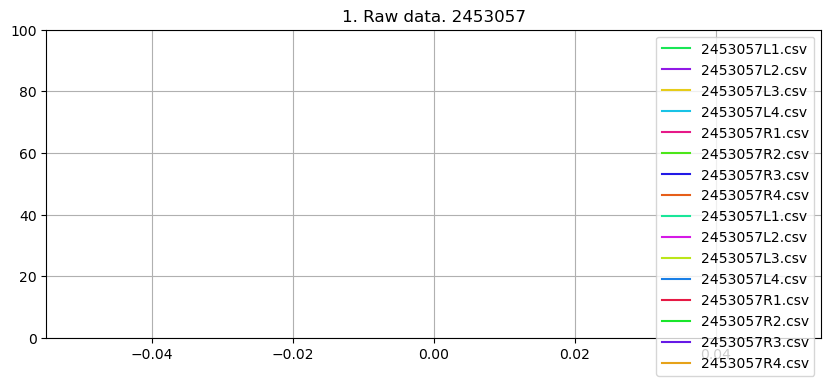

In [16]:
#Create report
def create_report(filtered_list):
    """This function creates a report"""
    jump_corrected_dict = []
    file_counter = 0
    
    #create a subfolder called report with the correction process info  
    report_path.mkdir(parents=True, exist_ok=True)

    #create report name
    new_file = os.path.join( report_path , f'original_data_{date}.pdf')

    #make a list of all files with code
    files_with_code = []
    for code in codes:
        files_with_code += [file for file in filtered_list if code in file]

    #print(f"{files_with_code=}")
    
    #create a report in pdf
    with matplotlib.backends.backend_pdf.PdfPages(new_file) as pdf:
        
        for code in codes: 
            #Code by code we will plot all the spectra with the same name
            code_file_counter = 1
            
            files_with_code = [file for file in filtered_list if code in file]
            
            plt.figure(figsize=(10, 4))
            
            for file in files_with_code:
                
                #print(f"{code_file_counter}")
                
                #create a spectrum object
                collection = Specimen_Collection.collection_lookup(code, collection_list)
                spectrum = Spectrum(file, collection)
                
                metadata, df = spectrum.get_metadata(), spectrum.get_dataframe()
                filename = spectrum.get_filename()
                basename = Path(filename).name
                #After that we will average the spectra
                #create figure
                color = get_contrasting_color(code_file_counter)
                
                #print(f"measuring_mode")
                #plots before changes
                plt.plot(df["wavelength"], df[metadata["measuring_mode"]], color = color, label = f"{basename}")
                
                #If the file is a l1050 file it will be jump corrected
                #Fix jump correction
                if check_l1050_file(file):
                    df_corrected = jump_correction(spectrum)
                elif check_CRAIC_file(file): 
                    #If the file is a CRAIC file nothing must be done
                    df_corrected = spectrum.get_dataframe()
                else:
                    df_corrected = spectrum.get_dataframe()
                    
                corrected_dict = {"df":df_corrected, "complete_path": file, "metadata": metadata, "code":code}
                
                jump_corrected_dict.append(corrected_dict)
                save_corrected_df(df_corrected, filename, metadata)
                
                code_file_counter += 1
                file_counter += 1
                ### end for
                
            plt.title(f'1. Raw data. {code}')
            plt.ylim(0,100)
            plt.legend()
            plt.grid(True)
            #plt.show()
            pdf.savefig()
            plt.close()

create_report(successful_list_without_excluded_files)

#calculate averages

In [ ]:
def get_files_with_same_name(filtered_list):
    #get files in directory
    files = []
    for file in filtered_list:
        files.append( os.path.basename(file))
    
    #print(files)
    
    sample_names = []
    lambda1050_regex = r"([a-zA-Z\d]+)(?:-\d)*(?:.Sample)*.(?:txt)*(?:ASC)*"
    craic_regex_1 = r"(\d*)([RLO])(\d*)"
    craic_regex_2 = r"([a-zA-Z\d]*)_([RLO])_(\d*)"
    regexs =[lambda1050_regex, craic_regex_1, craic_regex_2]  
    #Names are in the form CODE-MEASUREMENTNUMBER.TXT
    for file in files:
        #print(file)
        p = re.compile(re1)
        m = p.match(file)
        if m:
            sample_names.append(m.group(1))

    return set(sample_names)

In [ ]:
var_dataframes = None
def average_files(file_list, code_set, directory, pdf):

    #parent directory and save_directory
    jump_corrected_path = os.path.join( directory , "jump_corrected_files")
    save_directory = os.path.dirname(jump_corrected_path)
    
    #print(f"{save_directory=}")
    file_counter = 0

    #Look for every available code in the folder
    for code in code_set:
        print(f"{code=}") 
        
        dataframes = []
        files_with_code =[file for file in file_list if code in Path(file).name] #gets each file that starts with the code provided
        print(files_with_code)
        
        # Read each file, create dataframes, and plot them
        for file_path in file_list:
            #print(f"{file_path=}")
            #create spectrum object
            collection = Specimen_Collection.collection_lookup(code, collection_list)
            spectrum = Spectrum(file_path, collection_list)
            
            #get metadata and dataframe
            #print("Reading file...")
            #print("Getting metadata and dataframe...")
            metadata, df = spectrum.get_metadata(), spectrum.get_dataframe()

            #metadata info
            measuring_mode = metadata["measuring_mode"]
            sample_name = metadata["code"] 

            # Read the file into a pandas DataFrame
            #convert columns to float
            #print("Converting columns to float...")
            df['wavelength'] = df['wavelength'].astype(float)
            df[measuring_mode] = df[measuring_mode].astype(float)
            
            #print("Dropping index...")
            try:
                df = df.drop("index", axis = 1)
            except Exception as e:
                #print (e)
                pass
            #print("Printing head...")
            
            #print(df.head())
            # Append the dataframe to the list if not empty
            if not df.empty and not None and len(df) != 0:
                dataframes.append(df) 
            
        # Calculate the average of all dataframes ignore empty ones
        # average l1050 files and polarization_sum CRAIC files
        print("elements")
        
        #print(dataframes)
        print(len(dataframes))

        #If there are no dataframes, continue
        if len(dataframes) == 0:
            continue
        #If there is only one 
        elif len(dataframes) == 1:
            average_df = dataframes[0]
            std_dev_df = pd.DataFrame([])
        #If there are many
        else:
            average_df = pd.concat(dataframes).groupby('wavelength').mean().reset_index()
            std_dev_df = pd.concat(dataframes).groupby('wavelength').std().reset_index()

        try: 
            #print(f"{average_df=}")
            
            #average plot
            avg_plot = average_df.plot(x='wavelength', y=measuring_mode, kind='scatter', s=markersize, title = sample_name + " avg", figsize = (10, 4), grid=True)
            #save figures
            plt.ylim(0,y=)
            pdf.savefig()
            #close plot
            plt.close()
            
            #standard deviation plot
            std_plot = std_dev_df.plot(x='wavelength', y=measuring_mode, color = "r", kind='scatter', s=markersize, title = sample_name + " std dev", figsize = (10,4), grid=True)
            #save figures
            pdf.savefig()
            #close plot
            plt.close()
        except Exception as e:
            print(e)
            
        #SAVE FILE
        #Convert to numpy
        average_np = average_df.to_numpy()
        std_dev_np = std_dev_df.to_numpy()
        
        #Create new folder
      
        avg_new_path = os.path.join(save_directory , "average")
        std_dev_new_path = os.path.join(save_directory , "std_dev") 

        
        if not os.path.exists(avg_new_path):
            os.mkdir(avg_new_path)
        if not os.path.exists(std_dev_new_path):
            os.mkdir(std_dev_new_path)

        #creates new filename
        #print(f"sample name: {sample_name}")

        new_avg_archive_name = os.path.join(avg_new_path, sample_name+'.txt')
        new_std_dev_archive_name = os.path.join( std_dev_new_path , sample_name+'.txt')

        #print(new_avg_archive_name)
        #saves files
        np.savetxt(new_avg_archive_name, average_np,fmt = "%.6f", delimiter="\t", header=metadata["header"], comments='')
        np.savetxt(new_std_dev_archive_name, std_dev_np,fmt = "%.6f", delimiter="\t", header=metadata["header"], comments='')
        #print("fin de la iteracion")

        def delete_blank_row(archive_name):
            with open(archive_name, "r") as f:
                data = f.read()
            with open(archive_name, "w") as f:
                f.write(data.replace("#DATA\n","#DATA"))

        delete_blank_row(new_avg_archive_name)
        delete_blank_row(new_std_dev_archive_name)
                         
        file_counter = file_counter +1
        
    print(f"{file_counter} averages were calculated")
    print(f"Report file is located in {save_directory}")
        
        

In [ ]:
### Calculate the average for each spectrum if it has the same name

In [ ]:
### Calculate the average for each spectrum if it has the same name
### And create a p
avg_std_report_file = report_path.parent/ Path(parent_folder_data_path).name / "average_and_std_report.pdf"
#print(avg_std_report_file)

with matplotlib.backends.backend_pdf.PdfPages(avg_std_report_file) as pdf:
    code_set = get_files_with_same_name(successful_list_without_excluded_files)
    #print(code_set)
    average_files(successful_list_without_excluded_files, code_set, parent_folder_data_path , pdf)

#Create jump_corrected_files report

avg_std_report_file = os.path.join(report_path, "detector_jump_correction_report.pdf")
print(avg_std_report_file)

with matplotlib.backends.backend_pdf.PdfPages(avg_std_report_file) as pdf:
    
    jump_corrected_path = os.path.join(parent_folder_data_path , "jump_corrected_files")

    code_set = get_files_with_same_name(jump_corrected_path)

    average_files(successful_list_without_excluded_files, code_set, jump_corrected_path, pdf)

        
        